# Zindi Image classification (Binary)

In [1]:
# Import packages

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.image as img # to read images

import os                      # to generate new file directories
import shutil                  # to move files
from tqdm import tqdm          # to see process bar

import glob                    # to gather jpg files
from glob import glob

import tensorflow as tf

# Input your own file directory

In [3]:
# Input your file directory

file_dir = 'D:/thon/DL/zindi' # Change here with your file directory

In [6]:
# Read train, test and submission csv files

train_df = pd.read_csv(file_dir + '/New_Train.csv')
test_df = pd.read_csv(file_dir + '/Test.csv')
sample_sub = pd.read_csv(file_dir + '/SampleSubmission.csv')

print("The number of New_train data is ", len(train_df['Image_id']))
print(train_df.head())
print('\n')
print(test_df.head())
print('\n')
print("The number of test data is ", len(test_df['Image_id']))
print(np.sum(test_df['Image_id'] == sample_sub['Image_id'])) # Test.csv and SampleSubmission.csv's Image_id is identical

The number of New_train data is  891
               Image_id  Label
0  id_02mh3w48pmyc9.jpg      0
1  id_02rpb463h9d3w.jpg      0
2  id_02wc3jeeao8ol.jpg      1
3  id_04xrxyd43rlgz.jpg      0
4  id_082w0qygo3eth.jpg      0


               Image_id
0  id_00exusbkgzw1b.jpg
1  id_03dqinf6w0znv.jpg
2  id_046yl0cxn3ybz.jpg
3  id_04athdtx2abyg.jpg
4  id_062aauf9e9jk0.jpg


The number of test data is  1080
1080


# Managing Image directories and files

## You don't need to do it twice

In [10]:
### You don't need to do it twice

# Set an image directory
img_dir = file_dir + '/Images'

# Set train and test directories

train_dir = img_dir + '/imbalanced_train'
test_dir = img_dir + '/test'

# Generate '0' / '1' label folder in 'train' folder

os.makedirs(train_dir + '/1')
os.makedirs(train_dir + '/0')

# Set train label 0 and 1 directories

train1_dir = train_dir + '/1'
train0_dir = train_dir + '/0'


### To move files according to train.csv and test.csv's 'Image_id' column

train_file_name = train_df["Image_id"]
train_file_label = train_df["Label"]

# Separate train images to '0' / '1' label folder

for i, name in enumerate(train_file_name):
    file_source = train_dir + f'/{name}'
    file_destination_1 = train1_dir # for Label 1
    file_destination_0 = train0_dir # for Label 0

    if train_file_label[i] == 1:
        shutil.move(file_source, file_destination_1)
    else:
        shutil.move(file_source, file_destination_0)

# Image preprocessing

In [13]:
### Image preprocessing
# Set batch_size, img_height, img_width

batch_size = 32
img_height = 180
img_width = 180


# Train image dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2, # 891 * 0.8 = 713 images are for train dataset
    label_mode = 'binary',
    subset = 'training',
    shuffle = True,
    seed = 2021120087,
    image_size = (img_height, img_width),
    batch_size = batch_size)

print('\n')

# Validation image dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    validation_split = 0.2, # 891 * 0.2 = 178 images are for validation dataset
    label_mode = 'binary',
    subset = "validation",
    shuffle = True,
    seed = 2021120087,
    image_size = (img_height, img_width),
    batch_size = batch_size)

print('\n')

# Test image dataset

test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    label_mode = None,
    shuffle = False,
    image_size = (img_height, img_width),
    batch_size = batch_size)

Found 891 files belonging to 2 classes.
Using 713 files for training.


Found 891 files belonging to 2 classes.
Using 178 files for validation.


Found 1080 files belonging to 1 classes.


In [14]:
# Class names (Labels)

class_names = train_ds.class_names
print(class_names)


# Check the train image shapes

for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

['0', '1']
(32, 180, 180, 3)
(32, 1)


# Define Model using tensorflow

In [19]:
# ConvNet layers

from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape = (180, 180, 3))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs = inputs, outputs = outputs)

# Model summary

model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 180, 180, 3)]     0         
_________________________________________________________________
rescaling_2 (Rescaling)      (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 178, 178, 32)      896       
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 89, 89, 32)        0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 87, 87, 64)        18496     
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 43, 43, 64)        0         
_________________________________________________________________
conv2d_12 (Conv2D)           (None, 41, 41, 128)       7385

# Train model

In [20]:
# Compile model

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['AUC']
)

# Train model

history = model.fit(train_ds, validation_data = val_ds, epochs = 20, batch_size = batch_size)

Epoch 1/20
23/23 [==============================] - 3s 96ms/step - loss: 0.3425 - auc: 0.5557 - val_loss: 0.5058 - val_auc: 0.6761
Epoch 2/20
23/23 [==============================] - 2s 88ms/step - loss: 0.3613 - auc: 0.5436 - val_loss: 0.3083 - val_auc: 0.5802
Epoch 3/20
23/23 [==============================] - 2s 88ms/step - loss: 0.3129 - auc: 0.5643 - val_loss: 0.3658 - val_auc: 0.6786
Epoch 4/20
23/23 [==============================] - 2s 89ms/step - loss: 0.3048 - auc: 0.6298 - val_loss: 0.2922 - val_auc: 0.6603
Epoch 5/20
23/23 [==============================] - 2s 89ms/step - loss: 0.2482 - auc: 0.7995 - val_loss: 0.2722 - val_auc: 0.7822
Epoch 6/20
23/23 [==============================] - 2s 88ms/step - loss: 0.2353 - auc: 0.8490 - val_loss: 0.3127 - val_auc: 0.7834
Epoch 7/20
23/23 [==============================] - 2s 88ms/step - loss: 0.2424 - auc: 0.8249 - val_loss: 0.2791 - val_auc: 0.7822
Epoch 8/20
23/23 [==============================] - 2s 88ms/step - loss: 0.1647 - a

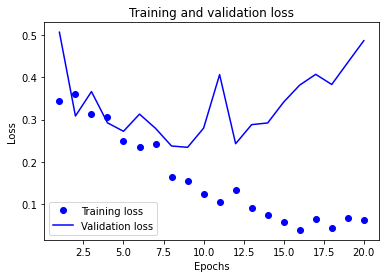

In [21]:
# Visualize validation loss and accuracy loss

history_dict = history.history
loss_values = history_dict["loss"]
val_loss_values = history_dict["val_loss"]
epochs = range(1, len(loss_values) + 1)
plt.plot(epochs, loss_values, "bo", label = "Training loss")
plt.plot(epochs, val_loss_values, "b", label = "Validation loss")
plt.title("Training and validation loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# To find the best model

In [22]:
### Find the best model using callbacks
# Define model again

inputs = keras.Input(shape = (180, 180, 3))
x = layers.experimental.preprocessing.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters = 32, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 64, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 128, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu")(x)
x = layers.MaxPooling2D(pool_size = 2)(x)
x = layers.Conv2D(filters = 256, kernel_size = 3, activation = "relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(1, activation = "sigmoid")(x)
model = keras.Model(inputs = inputs, outputs = outputs)

# Compile model

model.compile(
    optimizer = 'adam',
    loss = 'binary_crossentropy',
    metrics = ['AUC']
)

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath = "convnet.keras.imbalanced", # Save the best model as 'convnet.kears.imbalanced'
        save_best_only = True,
        monitor = "val_loss")
]

history_test = model.fit(
    train_ds,
    epochs = 50,
    validation_data = val_ds,
    callbacks = callbacks)

Epoch 1/50
23/23 [==============================] - 3s 98ms/step - loss: 0.3841 - auc: 0.4629 - val_loss: 0.3155 - val_auc: 0.5581
INFO:tensorflow:Assets written to: convnet.keras.imbalanced\assets
Epoch 2/50
23/23 [==============================] - 3s 96ms/step - loss: 0.3076 - auc: 0.5590 - val_loss: 0.3098 - val_auc: 0.6497
INFO:tensorflow:Assets written to: convnet.keras.imbalanced\assets
Epoch 3/50
23/23 [==============================] - 3s 96ms/step - loss: 0.3490 - auc: 0.5649 - val_loss: 0.3395 - val_auc: 0.6331
Epoch 4/50
23/23 [==============================] - 2s 89ms/step - loss: 0.3008 - auc: 0.6240 - val_loss: 0.2791 - val_auc: 0.7687
INFO:tensorflow:Assets written to: convnet.keras.imbalanced\assets
Epoch 5/50
23/23 [==============================] - 2s 88ms/step - loss: 0.2598 - auc: 0.7777 - val_loss: 0.2430 - val_auc: 0.8299
INFO:tensorflow:Assets written to: convnet.keras.imbalanced\assets
Epoch 6/50
23/23 [==============================] - 2s 88ms/step - loss: 0.21

In [32]:
print(np.min(history_test.history["val_loss"]), np.max(history_test.history["val_auc"]))

0.20528709888458252 0.9103009104728699


In [33]:
# Fit the best model

test_model = keras.models.load_model("convnet.keras.imbalanced")
# load the best model which we defined "convnet.keras"

predictions = test_model.predict(test_ds)
prediction_classes = [
    1 if prob > 0.5 else 0 for prob in np.ravel(predictions)
]

sample_sub["Label"] = prediction_classes
sample_sub.head()

,Image_id,Label
0,id_00exusbkgzw1b.jpg,0
1,id_03dqinf6w0znv.jpg,0
2,id_046yl0cxn3ybz.jpg,1
3,id_04athdtx2abyg.jpg,0
4,id_062aauf9e9jk0.jpg,0


In [34]:
# Save csv file

sample_sub.to_csv("Submission_imbal.csv", index = False)